In [21]:
import tensorflow_datasets as tfds

(train, test), info = tfds.load("tf_flowers",
                                split=["train[:80%]", "train[80%:]"],
                                as_supervised=True,
                                with_info=True)
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/home/raphael/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [22]:
info.features['label'].names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

img_shape: (333, 500, 3), label: 2
img_shape: (212, 320, 3), label: 3
img_shape: (240, 320, 3), label: 3
img_shape: (240, 320, 3), label: 4
img_shape: (317, 500, 3), label: 3
img_shape: (212, 320, 3), label: 0
img_shape: (240, 240, 3), label: 0
img_shape: (333, 500, 3), label: 0


2024-12-04 10:51:50.799606: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


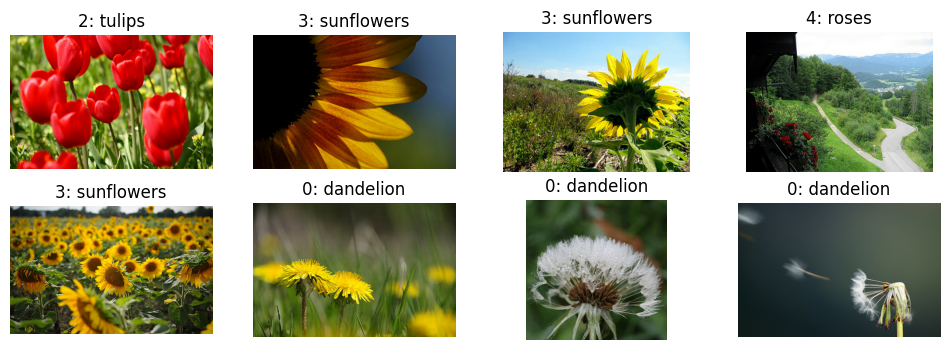

In [23]:
import matplotlib.pyplot as plt

label_names = info.features['label'].names
fig, axes = plt.subplots(2,4, figsize=(12,4))
for i, img_sample in enumerate(train.take(8)):
    print(f"img_shape: {img_sample[0].shape}, label: {img_sample[1]}")
    ax = axes.flatten()[i]
    ax.imshow(img_sample[0])
    ax.set_title(f"{img_sample[1]}: {label_names[img_sample[1]]}")
    ax.axis("off")

In [24]:
import tensorflow as tf
def preprocess_images(img, label, img_shape=(120,120)):
    img = tf.image.resize(img, img_shape) / 255.0
    return img, label

input_shape = 120, 120, 3
batch_size = 32

train_batch = train.shuffle(buffer_size=600).map(preprocess_images).batch(batch_size).prefetch(1)
test_batch = test.map(preprocess_images).batch(batch_size).prefetch(1)


In [25]:
from keras.applications import Xception

feature_extractor = Xception(weights="imagenet", include_top=False, input_shape=(input_shape))


In [26]:
import keras
from keras import layers
model = keras.Sequential([
    feature_extractor,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu", kernel_initializer="he_normal"),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu", kernel_initializer="he_normal"),
    layers.Dropout(0.5),
    layers.Dense(5, activation="softmax")
])

for layer in feature_extractor.layers:
    layer.trainable = False

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,387,309 (81.59 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [27]:
model.fit(train_batch, epochs=20, validation_data=test_batch)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 324ms/step - accuracy: 0.5448 - loss: 1.2340 - val_accuracy: 0.7929 - val_loss: 0.5811
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 302ms/step - accuracy: 0.7497 - loss: 0.6728 - val_accuracy: 0.8093 - val_loss: 0.5059
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 313ms/step - accuracy: 0.7917 - loss: 0.5810 - val_accuracy: 0.8270 - val_loss: 0.4841
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 326ms/step - accuracy: 0.8182 - loss: 0.5132 - val_accuracy: 0.8351 - val_loss: 0.4685
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 331ms/step - accuracy: 0.8308 - loss: 0.4839 - val_accuracy: 0.8215 - val_loss: 0.4668
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 326ms/step - accuracy: 0.8270 - loss: 0.4595 - val_accuracy: 0.8420 - val_loss: 0.4447
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 337ms/step - accuracy: 0.8404 - loss: 0.4213 - val_accuracy: 0.8447 - val_loss: 0.4458
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 329ms/step - accuracy: 0.8623 - loss: 0.3900 - val_accu

<Axes: >

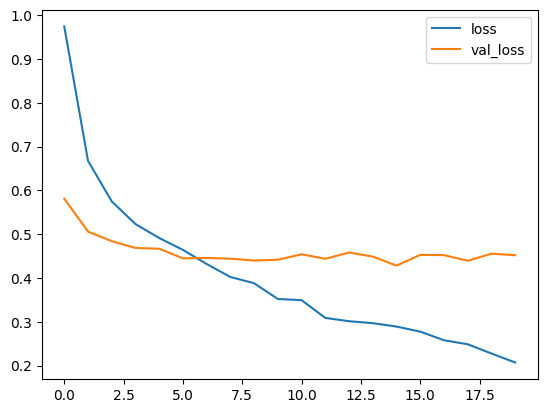

In [29]:
import pandas as pd
metrics = pd.DataFrame(model.history.history)

metrics[["loss", "val_loss"]].plot()

<Axes: >

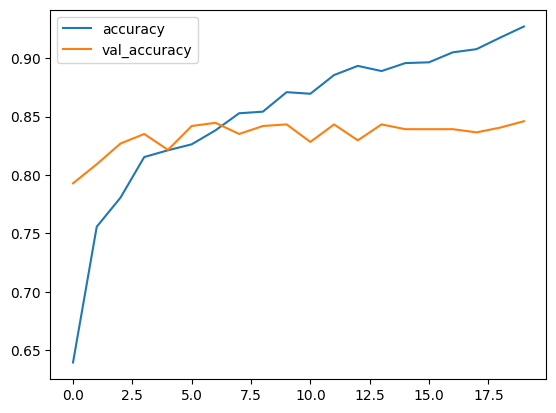

In [30]:
metrics[["accuracy", "val_accuracy"]].plot()